# Handling time to event outcome (Survival analysis)

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as st
from lifelines import KaplanMeierFitter, NelsonAalenFitter, CoxPHFitter
from lifelines.statistics import logrank_test

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style = 'whitegrid')

## Introduction

Extending our discussion from previous lecture, where we learnt about binary outcomes (success/no success) and means to describe them (with probability of success under bernoulli probability distribution) and analyse them, in this lecture we will describe the binary outcomes when there is time duration involved.

The above analyses come under the purview of **time to event** analysis.

## Ways to look at the outcome

There are two ways to look into the time to event outcomes:

1. **Time elapsed from start when event occurs.** This outcome measure is a **continuous** one restricting to **positive real numbers** only. The **probability distributions** which can describe these durations are **exponential**, **lognormal**, **weibull**, and **gamma** probability distributions. These are usually right skewed and are described by rank based measures or by value based methods as described in previous lectures.

2. **Probability of occurrence of event at a defined time point.** This outcome measure is a **binary** one and we estimate the probability by **calculating proportion of sample achieving the specified event at the defined time point**.

## Generating sample from underlying probability distribution with specified parameters (effects)

In [2]:
np.random.seed(100)

def create_df (N):
    '''
    N: sample size for each treatment
    '''
    
    lambda_1A = 0.01
    lambda_1B = 0.015
    lambda_2 = 0.1

    event_durations_A = st.expon.rvs(scale = 1 / lambda_1A, size = N) + st.expon.rvs(scale = 1 / lambda_2, size = N)
    censored_durations_A = np.random.randint(low = 1, high = event_durations_A.max(), size = N)

    durations_A = np.min(np.vstack([event_durations_A, censored_durations_A]), axis = 0)
    events_A = 1 * (event_durations_A <= censored_durations_A)

    event_durations_B = st.expon.rvs(scale = 1 / lambda_1B, size = N) + st.expon.rvs(scale = 1 / lambda_2, size = N)
    censored_durations_B = np.random.randint(low = 1, high = event_durations_B.max(), size = N)

    durations_B = np.min(np.vstack([event_durations_B, censored_durations_B]), axis = 0)
    events_B = 1 * (event_durations_B <= censored_durations_B)

    df_surv = pd.DataFrame({'duration':np.hstack([durations_A, durations_B]), \
                  'relapse': np.hstack([events_A, events_B]), \
                  'treatment': np.repeat(['A', 'B'], N)})
    
    return df_surv

In [3]:
df_surv = create_df(20)
df_surv.head(10)

duration  relapse treatment
0   14.000000        0         A
1   60.763267        1         A
2   31.000000        0         A
3   18.000000        0         A
4    2.401698        1         A
5   17.627215        1         A
6  111.150563        1         A
7  177.694635        1         A
8   30.579889        1         A
9    1.000000        0         A

## Why traditional binary outcome measures fail in setting of time to event analysis?

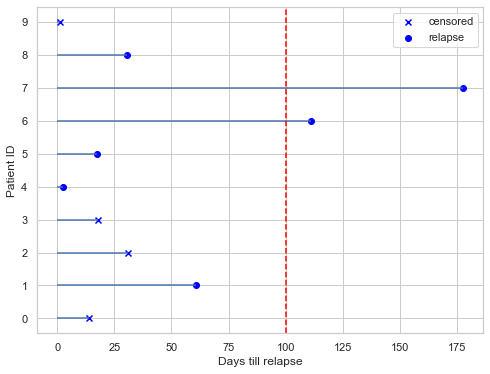

In [4]:
n_fig = 10

f, ax = plt.subplots(figsize = (8, 6))

ctr_rel = True
ctr_cens = True

for i in range(n_fig):
    mark = 'o' if df_surv.iloc[i, :]['relapse'] else 'x'
    lab = 'relapse' if df_surv.iloc[i, :]['relapse'] else 'censored'
    if lab == 'relapse':
        if ctr_rel:
            ax.scatter(df_surv.iloc[i, :]['duration'], i, c = 'blue', marker = mark, label = lab)
            ctr_rel = False
        else:
            ax.scatter(df_surv.iloc[i, :]['duration'], i, c = 'blue', marker = mark)
    if lab == 'censored':
        if ctr_cens:
            ax.scatter(df_surv.iloc[i, :]['duration'], i, c = 'blue', marker = mark, label = lab)
            ctr_cens = False
        else:
            ax.scatter(df_surv.iloc[i, :]['duration'], i, c = 'blue', marker = mark)            
    ax.hlines(i, 0, df_surv.iloc[i, :]['duration'])
ax.axvline(100, linestyle = 'dashed', color = 'red')
ax.set_xlabel('Days till relapse')
ax.set_ylabel('Patient ID')
ax.set_yticks(list(range(n_fig)))
_ = ax.legend()

In the above diagram, ticks on the **y axis** represent **patients** with id 0 to 9. Numbers on **x axis** represent the **duration (in days) till relapse**. If a line segment **ends with circle (o)**, the patient **relapses**. If a line segment **ends with cross (x)**, the patient **loses to follow up** and further data is not available for that patient after that time duration. The **red vertical line** represents **day 100 post follow up**. 

**We want to find out proportion of patients relapsed on day 100.**

**Had we known the outcome status of all the patients till day 100**, we could have obtained the $prop = \frac{num\ events}{total\ num}$.

Unfortunately, for **patients with id 0, 2, 3, 9**, we **donot know the event status on day 100** as we have **lost them before day 100 without them achieving the event (relapse)**. For patients with **id 6 and 7**, we definitely know that **they did not achieve event till day 100** and for the **rest** we definitely know that they **achieved event (relapse)**.

It is because of the **presence of patients with unknown event status on the day of assessment** due to their **loss to follow up**, that the **traditional binary outcome measures fail** to reflect probability of achieving event on the day of assessment and specialised techniques are used. 

## Concept of Censoring

Understanding the concept of censoring is central to understand time to event data.

We will be considering **right censoring** in this lecture. In addition there are left and interval censoring.

**Right Censoring** is the process in which a **patient goes out of follow up before he/she achieves the event**. Noting time to censoring is important because it gives us information that the patient did not achieve event till that duration.

It is assumed, **process of right censoring and process of achieving event are independent to each other**. It means that even after a patient is right censored, he/she will achieve the event with the same probability as another patient who is still under follow up.

So, if a patient **dies before achieving relapse**, he/she is **not censored** because the event of death prevents the patient from achieving the event of relapse. Event of death is a **competing risk**.

Also, if a patient is **lost to follow up** due to **any reason which increases his/her chances of relapsing**, he/she is **not censored**.

<a id='effect'></a>
## Effects

Some of the **effects** (**parameters** of underlying probabilistic process), we want to estimate (with samples), for time to event analysis are:

1. **Survival at time t, $S(t)$:** It is the probability that event is not achieved till time t.

2. **Hazard at time t, $h(t)$:** It is the probability that event is achieved at time t, given it has not occurred before time t.

3. **Cumulative incidence of event at time t, $C(t)$:** It is the probability that event has occurred before or at time t. It is inverse of survival at time t, $1 - S(t)$, except when there are competing risks.

4. **Hazard ratio at time t, $\frac{h_B(t)}{h_A(t)}$:** It is ratio of hazard between group B and group A at time t. Ratio of 1 means no difference.

## Description of data

In [5]:
df_surv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   duration   40 non-null     float64
 1   relapse    40 non-null     int64  
 2   treatment  40 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ KB


In [6]:
df_surv['duration'].describe()

count     40.000000
mean      54.863075
std       53.855905
min        1.000000
25%       15.962197
50%       31.864882
75%       72.819064
max      206.554531
Name: duration, dtype: float64

In [7]:
df_surv['relapse'].value_counts()

1    26
0    14
Name: relapse, dtype: int64

In [8]:
df_surv['treatment'].value_counts()

B    20
A    20
Name: treatment, dtype: int64

## Estimation of survival function, $S(t)$

### Kaplan Meier Method

In [9]:
kmf = KaplanMeierFitter()

In [10]:
kmf.fit(durations = df_surv.duration, event_observed = df_surv.relapse)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 40 total observations, 14 right-censored observations>

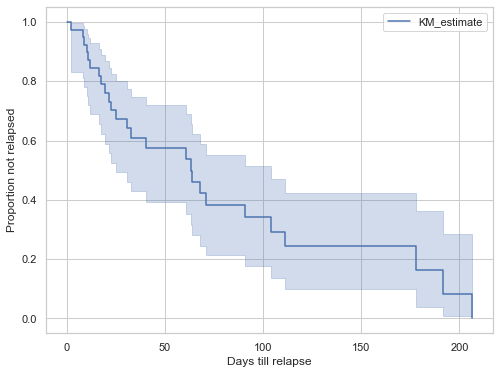

In [11]:
f, ax = plt.subplots(figsize = (8, 6))
ax = kmf.plot()
ax.set_xlabel('Days till relapse')
_ = ax.set_ylabel('Proportion not relapsed')

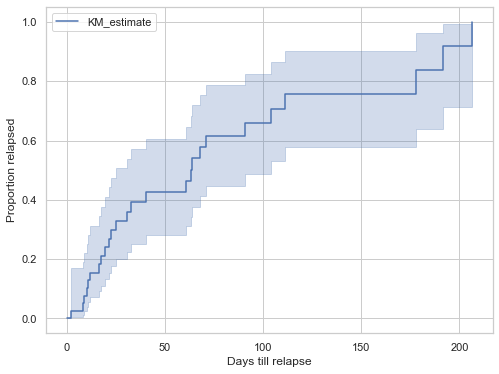

In [12]:
f, ax = plt.subplots(figsize = (8, 6))
ax = kmf.plot_cumulative_density()
ax.set_xlabel('Days till relapse')
_ = ax.set_ylabel('Proportion relapsed')

In [13]:
kmf.event_table.head(10)

removed  observed  censored  entrance  at_risk
event_at                                                 
0.000000         0         0         0        40       40
1.000000         1         0         1         0       40
2.401698         1         1         0         0       39
8.198565         1         1         0         0       38
8.887260         1         1         0         0       37
10.267789        1         1         0         0       36
10.831621        1         1         0         0       35
11.976417        1         1         0         0       34
14.000000        2         0         2         0       33
15.000000        1         0         1         0       31

In [14]:
kmf.survival_function_.head()

KM_estimate
timeline             
0.000000     1.000000
1.000000     1.000000
2.401698     0.974359
8.198565     0.948718
8.887260     0.923077

In [15]:
kmf.confidence_interval_survival_function_.head()

KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.000000                1.000000                1.000000
1.000000                1.000000                1.000000
2.401698                0.831593                0.996348
8.198565                0.810158                0.986922
8.887260                0.780163                0.974522

In [16]:
kmf.median_survival_time_

63.10920036158386

## Comparing survival function between two groups

Let us compare survival function between treatment A and treatment B.

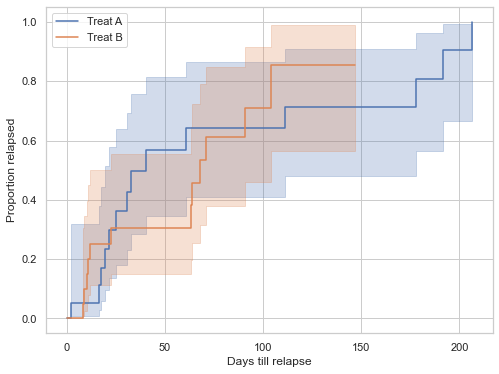

In [17]:
f, ax = plt.subplots(figsize = (8, 6))
kmf.fit(durations = df_surv.loc[df_surv.treatment == 'A', 'duration'], \
        event_observed = df_surv.loc[df_surv.treatment == 'A', 'relapse'])
kmf.plot_cumulative_density(ax = ax, label = 'Treat A')

kmf.fit(durations = df_surv.loc[df_surv.treatment == 'B', 'duration'], \
        event_observed = df_surv.loc[df_surv.treatment == 'B', 'relapse'])
kmf.plot_cumulative_density(ax = ax, label = 'Treat B')

ax.legend()

ax.set_xlabel('Days till relapse')
_ = ax.set_ylabel('Proportion relapsed')

In [18]:
logrank_test(durations_A = df_surv.loc[df_surv.treatment == 'A', 'duration'], \
             durations_B = df_surv.loc[df_surv.treatment == 'B', 'duration'], \
             event_observed_A = df_surv.loc[df_surv.treatment == 'A', 'relapse'], \
             event_observed_B = df_surv.loc[df_surv.treatment == 'B', 'relapse'])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.01 0.91      0.13

<a id="samp-size-surv"></a>
## Increasing precision and power by increasing sample size (200)

In [19]:
df_surv_200 = create_df(200)

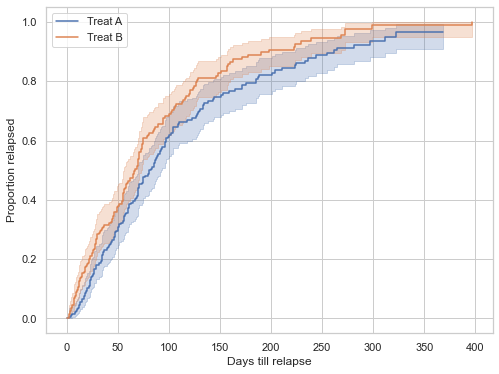

In [20]:
f, ax = plt.subplots(figsize = (8, 6))
kmf.fit(durations = df_surv_200.loc[df_surv_200.treatment == 'A', 'duration'], \
        event_observed = df_surv_200.loc[df_surv_200.treatment == 'A', 'relapse'])
kmf.plot_cumulative_density(ax = ax, label = 'Treat A')

kmf.fit(durations = df_surv_200.loc[df_surv_200.treatment == 'B', 'duration'], \
        event_observed = df_surv_200.loc[df_surv_200.treatment == 'B', 'relapse'])
kmf.plot_cumulative_density(ax = ax, label = 'Treat B')

ax.legend()

ax.set_xlabel('Days till relapse')
_ = ax.set_ylabel('Proportion relapsed')

In [21]:
logrank_test(durations_A = df_surv_200.loc[df_surv_200.treatment == 'A', 'duration'], \
             durations_B = df_surv_200.loc[df_surv_200.treatment == 'B', 'duration'], \
             event_observed_A = df_surv_200.loc[df_surv_200.treatment == 'A', 'relapse'], \
             event_observed_B = df_surv_200.loc[df_surv_200.treatment == 'B', 'relapse'])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           7.37 0.01      7.24

## Regression Model

### Cox Proportional Hazard Regression Model

In [22]:
cph = CoxPHFitter()

In [23]:
cph.fit(df = df_surv, duration_col = 'duration', event_col = 'relapse', formula = 'treatment')

<lifelines.CoxPHFitter: fitted with 40 total observations, 14 right-censored observations>

In [24]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 40 total observations, 14 right-censored observations>
             duration col = 'duration'
                event col = 'relapse'
      baseline estimation = breslow
   number of observations = 40
number of events observed = 26
   partial log-likelihood = -70.75
         time fit was run = 2021-11-09 14:23:54 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
treatment[T.B]   0.05       1.05       0.43            -0.79             0.88                 0.45                 2.42

                  z    p   -log2(p)
covariate                          
treatment[T.B] 0.11 0.91       0.13
---
Concordance = 0.50
Partial AIC = 143.49
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.13